In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import norm


#libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, truncnorm
from numpy.random import Generator, MT19937
import time
from scipy.special import logsumexp

In [2]:
#Initializing the random number generator
seed = int(time.time()) 
bitgen = MT19937(seed)
rng = Generator(bitgen)  # reproducible generator

In [3]:
#==========================Gaussian Target Distribution==========================
def target_pdf(x, mu=0, sigma=1.2):
    """
    Compute the PDF of a Gaussian distribution with mean 0 and standard deviation 1.
    """
    return norm.pdf(x, mu, sigma)

In [4]:
def metropolis_hastings(xo, thinning, burnin, N, step_size):

    
    """
    Perform Metropolis-Hastings sampling to generate samples from a Gaussian distribution.
    
    Parameters:
    mu (float): Mean of the Gaussian distribution.
    sigma (float): Standard deviation of the Gaussian distribution.
    N (int): Number of samples to generate.
    
    Returns:
    np.ndarray: Array of samples from the Gaussian distribution.
    """
    accepted = 0
    samples = []
    x_current = xo  # Starting point
    
    for _ in range(N):
        # Propose a new sample from a normal distribution centered at the current sample
        x_proposed = x_current + rng.uniform(-step_size, step_size)
        
        # Compute acceptance ratio
        acceptance_ratio = target_pdf(x_proposed) / target_pdf(x_current) # this ratio assumes, that q(x_proposed | x_current) = q(x_current | x_proposed) = 1, which is the case for symmetric proposal distributions
        
        # Accept or reject the proposed sample
        if np.random.rand() < acceptance_ratio:
            x_current = x_proposed
            accepted += 1
        
        samples.append(x_current)
    # Calculate acceptance rate
    p_accept = accepted / len(samples)
    # Thinning: only keep every 'thinning'-th sample
    samples = samples[::thinning]
    # Burn-in: discard the first 'burnin' samples
    samples = samples[burnin:]
    samples = np.array(samples)
    
    print(p_accept)
    
    return np.array(samples), p_accept

    # Generate N samples from the target distribution (standard normal) using rng

In [5]:
def importance_integration(f, N, rng, m_chain):
    # Compute the importance weights
    weights = f(m_chain) / target_pdf(m_chain)  # PDF of the target distribution
    estimate = np.mean(weights)  # Mean of the weights as the estimator of the integral
    
    return estimate

In [6]:
# Define the function f(x) = e^(-x^2)
def f(x):
    return np.exp(-x**2)


In [7]:
def blocking_variance(series, min_blocks=4):
    """
    Return
        bin_sizes  – powers-of-2 block lengths
        var_mean   – variance of the MCMC mean at each block size
        err_var    – 1-σ uncertainty of that variance
    """
    N = len(series)
    max_power = int(np.log2(N // min_blocks))
    bin_sizes = 2 ** np.arange(max_power + 1)

    var_mean, err_var = [], []
    for L in bin_sizes:
        n_blocks = N // L
        if n_blocks < min_blocks:               # need ≥ min_blocks estimates
            break
        # reshape   → one mean per block
        blocks = series[:n_blocks * L].reshape(n_blocks, L).mean(axis=1)

        s2      = blocks.var(ddof=1)            # unbiased σ² of block means
        v_mean  = s2 / n_blocks                 # Var[overall mean]
        var_mean.append(v_mean)

        # 1-σ error bar from χ² statistics
        err_var.append(v_mean * np.sqrt(2 / (n_blocks - 1)))

    return bin_sizes[:len(var_mean)], np.array(var_mean), np.array(err_var)

In [8]:
# ------------------------------------------------------------
# tiny plateau finder
# ------------------------------------------------------------
def plateau_variance(bin_sizes, variances, window=3, tolerance=0.05):
    """
    Mean of first 'window' consecutive points whose relative stdev < tolerance.
    Returns (variance_est, index_of_rightmost_point).
    """
    if len(variances) < window:
        return variances[-1], len(variances) - 1

    for i in range(len(variances) - window + 1):
        w = variances[i:i + window]
        if np.std(w) / np.mean(w) < tolerance:
            return np.mean(w), i + window - 1
    # fallback: last point
    return variances[-1], len(variances) - 1

0.45437
======  blocking-plateau variance estimate  ======
Var[mean] ≈ 4.1352e-05  ± 1.6e-06
Std error ≈ 6.4305e-03


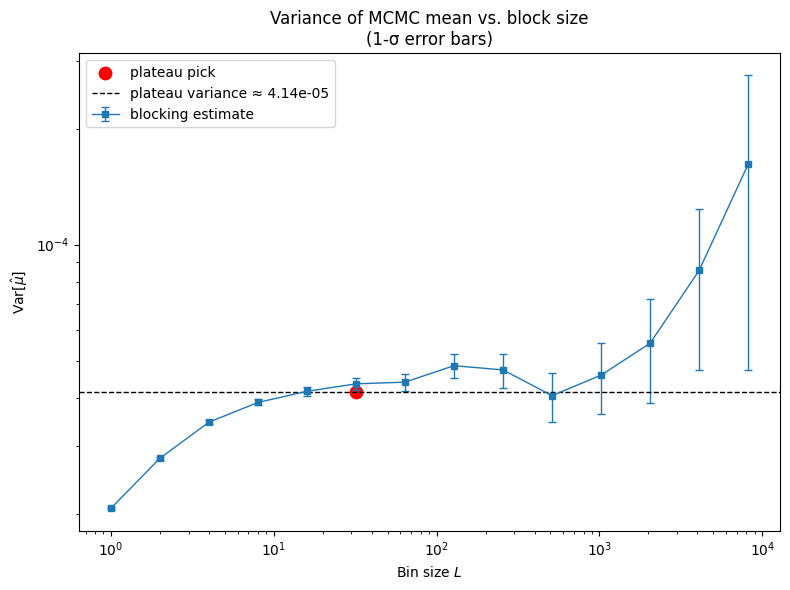

In [9]:
# --- 0. parameters ----------------------------------------

N = 100000  # Number of samples
step_size = 4  # Step size for the proposal distribution
xo = rng.uniform(-step_size, step_size)  # Initial point for the Markov chain rng.uniform(-step_size, step_size)
burnin = 1000  # Number of samples to discard as burn-in
thinning = 2  # Thinning factor for the Markov chain

# --- 1. generate a correlated chain (AR(1)) -----------------
markov_chain, prob_accept = metropolis_hastings(xo, thinning, burnin, N, step_size)

f_i = f(markov_chain)/ target_pdf(markov_chain)  # Importance weights for the samples

# --- 2. blocking analysis with error bars ------------------
bin_sizes, vars_mean, errs = blocking_variance(f_i)

# automatic plateau estimate
v_hat, idx = plateau_variance(bin_sizes, vars_mean)
err_hat    = errs[idx]

print("======  blocking-plateau variance estimate  ======")
print(f"Var[mean] ≈ {v_hat:.4e}  ± {err_hat:.1e}")
print(f"Std error ≈ {np.sqrt(v_hat):.4e}")

# 2. plot ----------------------------------------------------
plt.figure(figsize=(8, 6))
plt.errorbar(bin_sizes, vars_mean, yerr=errs,
             fmt='-s', capsize=3, linewidth=1, markersize=4,
             label='blocking estimate')
plt.scatter(bin_sizes[idx], v_hat, s=80, color='red',
            label='plateau pick')

# <<< NEW: horizontal line through the plateau value >>>
plt.axhline(v_hat, color='k', linestyle='--', linewidth=1,
            label=f'plateau variance ≈ {v_hat:.2e}')

plt.xscale('log'); plt.yscale('log')
plt.xlabel("Bin size $L$")
plt.ylabel(r"Var[$\hat\mu$]")
plt.title("Variance of MCMC mean vs. block size\n(1-σ error bars)")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()


In [10]:
def plateau_vs_N(N_vals,
                 *,
                 step_size=1,
                 burnin=1000,
                 thinning=2):
    """
    For every N in N_vals:
        • run a new MCMC chain
        • compute importance-weights series  f(chain)/target_pdf(chain)
        • do blocking + plateau pick
    Returns two NumPy arrays:  Ns,  plateau_variances
    """
    Ns   = []
    Vars = []

    for N in N_vals:
        # 1. run chain
        xo = rng.uniform(-step_size, step_size)
        chain, _ = metropolis_hastings(xo, thinning, burnin, N, step_size)

        # 2. observable series
        weights = f(chain) / target_pdf(chain)

        # 3. blocking → plateau variance
        bins, v, _ = blocking_variance(weights)
        v_hat, _   = plateau_variance(bins, v)

        Ns.append(N)
        Vars.append(v_hat)

    return np.array(Ns), np.array(Vars)


In [11]:
N_list = [5_000, 6000, 7000, 8000, 9000, 10_000, 12500, 15000, 20_000, 25000, 30000, 35000, 40_000]
Ns, plateau_var = plateau_vs_N(N_list, step_size=4, burnin=1000, thinning=2)

print("N       plateau-var")
for N, v in zip(Ns, plateau_var):
    print(f"{N:7d}   {v:.3e}")


0.4596
0.4598333333333333
0.465
0.456125
0.45066666666666666
0.456
0.45152
0.46073333333333333
0.4554
0.44848
0.45553333333333335
0.45454285714285714
0.45865
N       plateau-var
   5000   2.428e-03
   6000   1.103e-03
   7000   8.885e-04
   8000   4.689e-04
   9000   5.822e-04
  10000   4.916e-04
  12500   3.889e-04
  15000   2.848e-04
  20000   2.111e-04
  25000   1.752e-04
  30000   1.518e-04
  35000   1.198e-04
  40000   1.034e-04


In [12]:
from Uniform_MC import uniform_mc_integrate

estimate_u, variance_u, stderr_u = uniform_mc_integrate(f, a, b, N_list, rng)

a=-10
b=10

ModuleNotFoundError: No module named 'Uniform_MC'

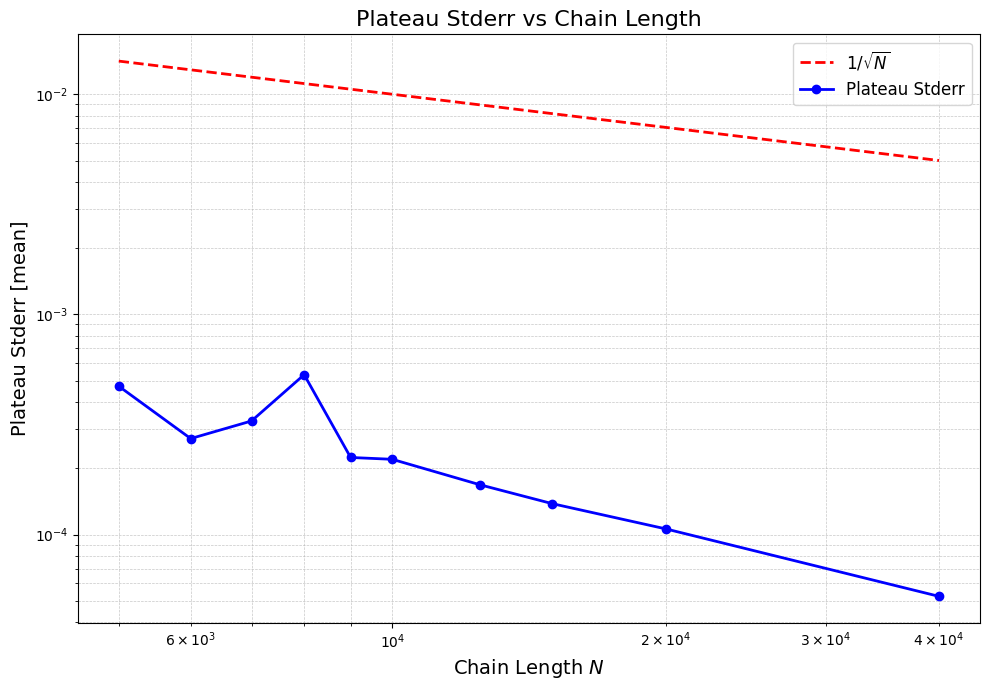

In [ ]:
plt.figure(figsize=(10, 7))

plt.loglog(Ns, 1 / np.sqrt(Ns), '--', color='red', linewidth=2, label=r'$1/\sqrt{N}$')
plt.loglog(Ns, np.sqrt(plateau_var/Ns), 'o-', color='blue', markersize=6, linewidth=2, label='Plateau Stderr')
plt.loglog(Ns, np.sqrt(stderr_u), 'o-', color='blue', markersize=6, linewidth=2, label='Uniform Stderr')

plt.xlabel("Chain Length $N$", fontsize=14)
plt.ylabel("Plateau Stderr [mean]", fontsize=14)
plt.title("Plateau Stderr vs Chain Length", fontsize=16)
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
